In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss,f1_score

import lightgbm as lgb

In [3]:
DIR = '/content/drive/MyDrive/Competitions/Signate/MUFJ'
INPUT_DIR = os.path.join(DIR,'input')
OUTPUT_DIR = os.path.join(DIR,'output')
OUTPUT_SUB_DIR = os.path.join(OUTPUT_DIR,'submission')

In [4]:
train_df = pd.read_csv(os.path.join(OUTPUT_DIR,"feature_train.csv"))
test_df = pd.read_csv(os.path.join(OUTPUT_DIR,"feature_test.csv"))

In [5]:
skf = StratifiedKFold(n_splits=5,shuffle=True,random_state=42)
for fold, ( _, val_) in enumerate(skf.split(train_df, train_df.state)):
    train_df.loc[val_ , "kfold"] = int(fold)
    
train_df["kfold"] = train_df["kfold"].astype(int)

In [6]:
test_drop_list = ["id","country","category1","category2","category3","country_category1","country_category2","country_category3","html_content","content","state"]
train_drop_list = test_drop_list + ["kfold"]

test_X = test_df.drop(test_drop_list, axis=1)

In [7]:
params = {
    "objective":"binary",
    "metric":"binary_logloss",
    "n_estimators":1000,
    "random_state":42
}

oof_df = pd.DataFrame()
lgb_importances = pd.DataFrame()
scores,preds = [],[]
for fold in range(5):
  print("="*15,f" fold = {fold} ","="*15)
  train_dataset = train_df.loc[train_df.kfold!=fold].reset_index(drop=True)
  valid_dataset = train_df.loc[train_df.kfold==fold].reset_index(drop=True)

  train_y = train_dataset.state.values
  train_x = train_dataset.drop(train_drop_list,axis=1)
  valid_y = valid_dataset.state.values
  valid_x = valid_dataset.drop(train_drop_list,axis=1)


  clf = lgb.LGBMClassifier(**params)
  clf.fit(train_x, train_y, eval_set=(valid_x, valid_y), early_stopping_rounds=100,
               verbose=500)
  
  val_pred = clf.predict(valid_x)
  #val_pred = np.where(val_pred_prob < 0.5, 0, 1)

  score = f1_score(valid_y, val_pred)
  scores.append(score)
  print(f"LGBM F1 Score : {score}")
  print()

  valid_dataset["pred_prob"] = val_pred
  oof_df = pd.concat([oof_df,valid_dataset])


  lgb_importances[f'importance_fold{fold}'] = clf.feature_importances_
  lgb_importances.set_index(train_x.columns, inplace=True)

===============  fold = 0  ===============
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[51]	valid_0's binary_logloss: 0.379003
LGBM F1 Score : 0.8083989501312336

===============  fold = 1  ===============
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[61]	valid_0's binary_logloss: 0.388305
LGBM F1 Score : 0.7972399150743099

===============  fold = 2  ===============
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[46]	valid_0's binary_logloss: 0.364459
LGBM F1 Score : 0.812664907651715

===============  fold = 3  ===============
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[47]	valid_0's binary_logloss: 0.377465
LGBM F1 Score : 0.8143958868894602

===============  fold = 4  ===============
Training until validation scores don't improve for 100 rounds.
Early stopping, best iterat

In [8]:
lgb_importances['avg'] = lgb_importances.mean(axis=1)
lgb_importances = lgb_importances.sort_values(by='avg',ascending=False)
lgb_importances['feature'] = lgb_importances.index

Text(0.5, 1.0, 'LightGBM feature importances')

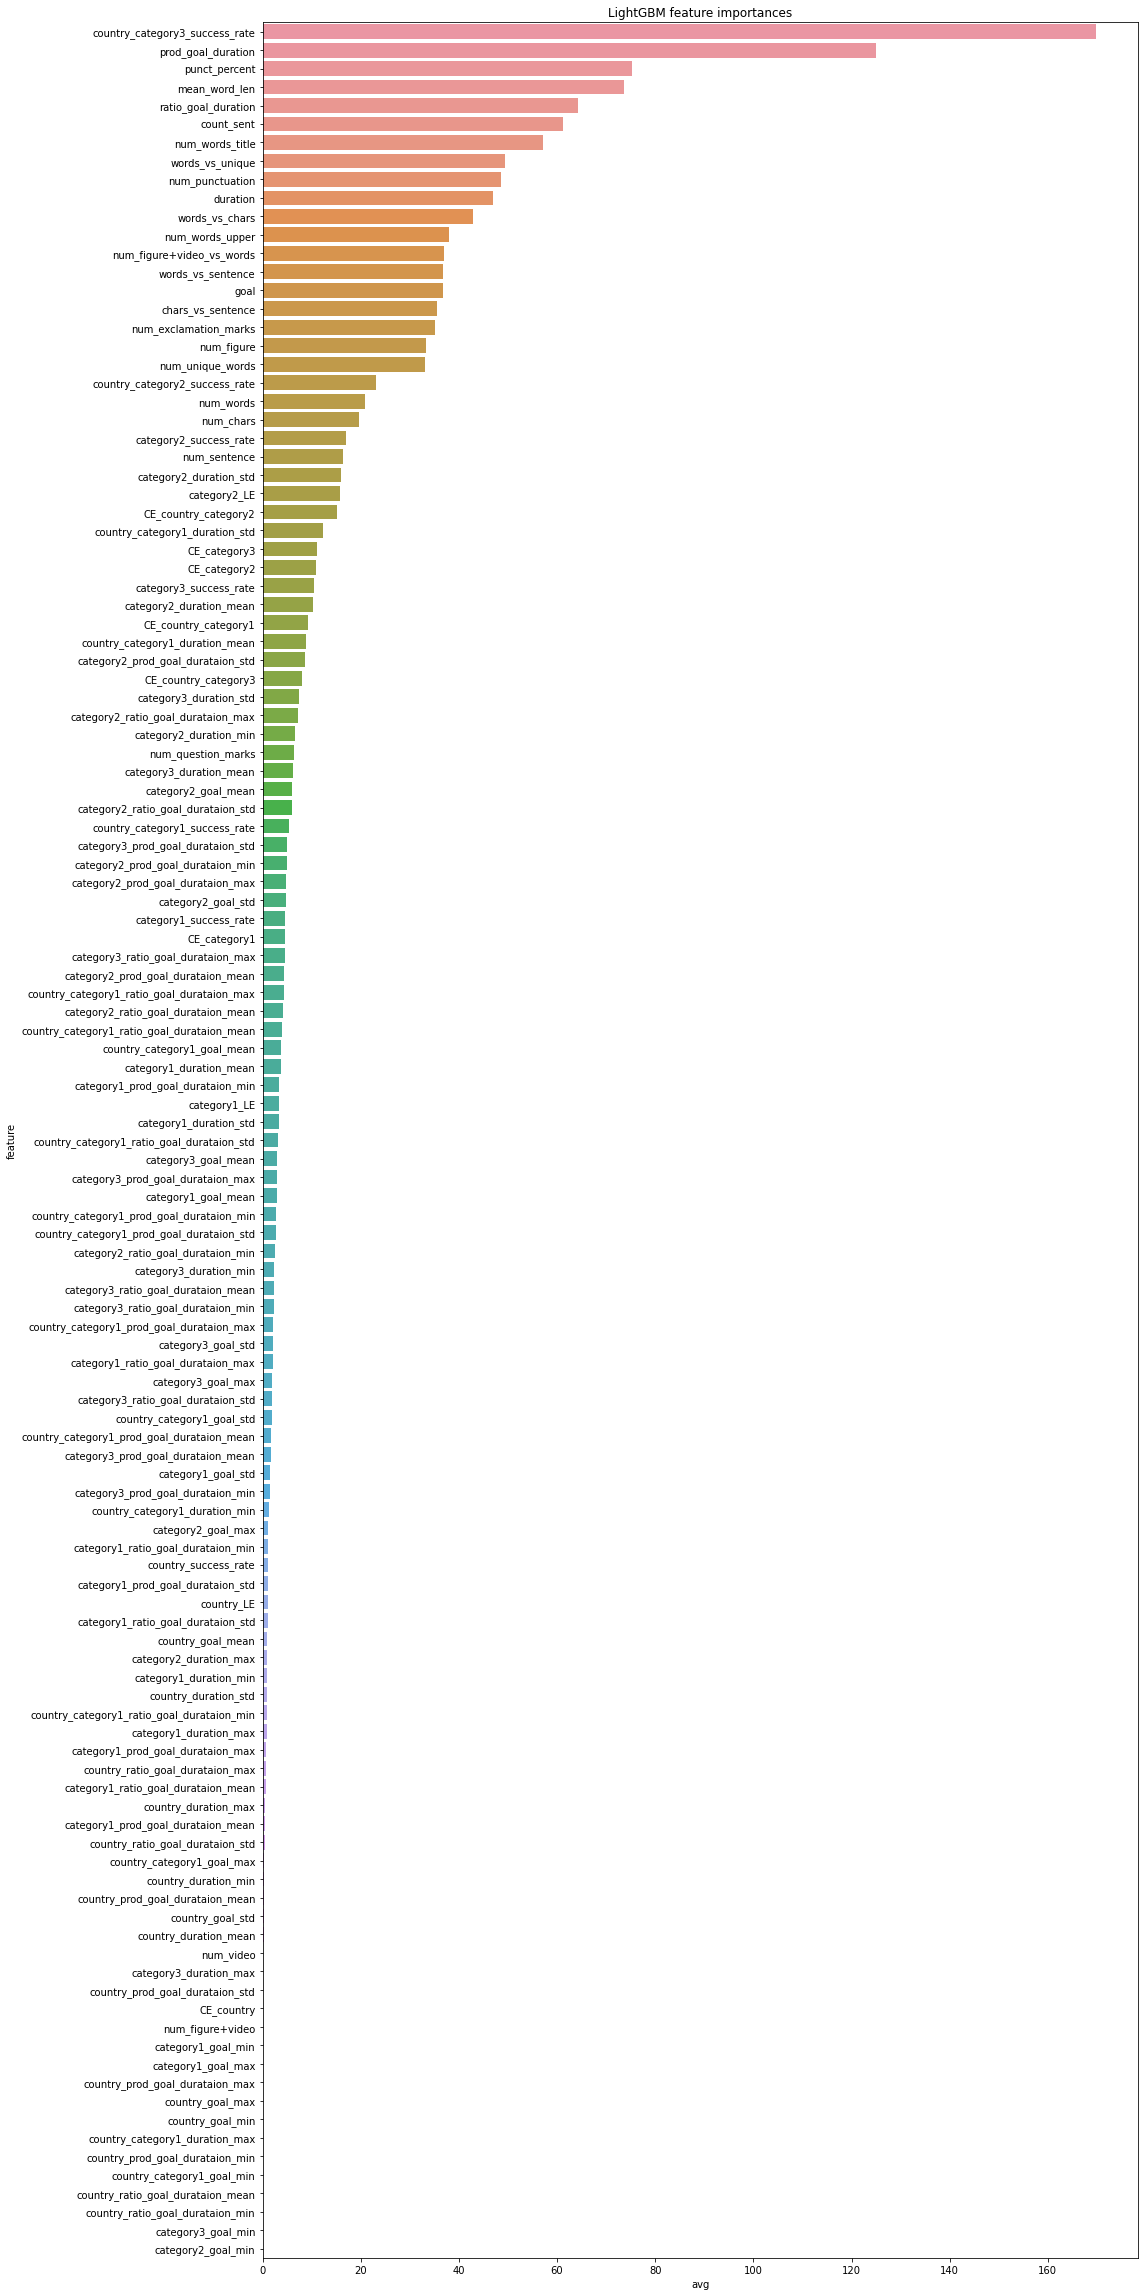

In [9]:
fig = plt.figure(figsize=(16, 32), tight_layout=True)
sns.barplot(x="avg", y="feature", data=lgb_importances)
plt.title("LightGBM feature importances")

In [10]:
data = lgb_importances.loc[lgb_importances.avg>0]
cols_top_7=data.avg.nlargest(7).index.tolist()

In [11]:
cols_top_7

['country_category3_success_rate',
 'prod_goal_duration',
 'punct_percent',
 'mean_word_len',
 'ratio_goal_duration',
 'count_sent',
 'num_words_title']

In [12]:
bottom_col = [col for col in data.index.to_list() if col not in cols_top_7]
bottom_col

['words_vs_unique',
 'num_punctuation',
 'duration',
 'words_vs_chars',
 'num_words_upper',
 'num_figure+video_vs_words',
 'words_vs_sentence',
 'goal',
 'chars_vs_sentence',
 'num_exclamation_marks',
 'num_figure',
 'num_unique_words',
 'country_category2_success_rate',
 'num_words',
 'num_chars',
 'category2_success_rate',
 'num_sentence',
 'category2_duration_std',
 'category2_LE',
 'CE_country_category2',
 'country_category1_duration_std',
 'CE_category3',
 'CE_category2',
 'category3_success_rate',
 'category2_duration_mean',
 'CE_country_category1',
 'country_category1_duration_mean',
 'category2_prod_goal_durataion_std',
 'CE_country_category3',
 'category3_duration_std',
 'category2_ratio_goal_durataion_max',
 'category2_duration_min',
 'num_question_marks',
 'category3_duration_mean',
 'category2_goal_mean',
 'category2_ratio_goal_durataion_std',
 'country_category1_success_rate',
 'category3_prod_goal_durataion_std',
 'category2_prod_goal_durataion_min',
 'category2_prod_goal